In [1]:
# This program is used to simulate gravimeter data, inject kicks and
# Simulate data retrival algoirthms through various noise sources.


#importing libraries
import csv
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import os
from scipy import signal
from scipy.optimize import curve_fit
from os import listdir
from os.path import isfile, join
import pylab
import numpy as np
import datetime


def gaussian(x,bb,cc,dd):
    hold=bb*np.exp(-1*(x-cc)**2/(2*dd**2))
    return hold




def data_trim(xdata,ydata,threshold):
    outx=[]
    outy=[]
    for i in range(len(xdata)):
        if np.abs(ydata[i])<threshold:
            outx.append(xdata[i])
            outy.append(ydata[i])
    return([outx,outy])

def data_trim_1D(ydata,threshold):
    outy=[]
    for i in range(len(ydata)):
        if np.abs(ydata[i])<threshold:
            outy.append(ydata[i])
    return(outy)

def outlier_reject_mean(datas,sigma_rej):
    import numpy as np
    mean_val=np.mean(datas)
    std_val=np.std(datas)
    dropped= [x for x in datas if -1*sigma_rej*std_val<=x-mean_val<=sigma_rej*std_val]
    return(np.mean(dropped),np.divide(np.std(dropped),np.sqrt(len(dropped))))

def outlier_reject_median(datas,sigma_rej):
    import numpy as np
    mean_val=np.median(datas)
    std_val=np.std(datas)
    dropped= [x for x in datas if -1*sigma_rej*std_val<=x-mean_val<=sigma_rej*std_val]
    return(np.mean(dropped),np.divide(np.std(dropped),np.sqrt(len(dropped))))


def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation
    outlier_ind=modified_z_score > thresh
    meanval=np.mean([points[i] for i in range(len(points)) if outlier_ind[i]==False])
    return meanval

# This looks for general domain walls, by fitting region widthb to the left, a region
# width b to the left, and seeing how those two regions disagree and the center
# Basically looks for step discontinuit
def Long_Region_N_Point_Poly_Filter(t,signal1,widthb,order):
    import numpy as np
    output=[]
    t_filt=[]
    for i in range(len(t)):
        if widthb+1<i<(len(t)-widthb-1):
            fit_regionx_left=t[i-widthb:i]
            fit_regiony_left=signal1[i-widthb:i]
            fit_regionx_right=t[i+1:i+widthb+1]
            fit_regiony_right=signal1[i+1:i+widthb+1]    
            if fit_regionx_right[-1]-fit_regionx_left[0]==(widthb*2)*60:
                p_left=np.polyfit(fit_regionx_left,fit_regiony_left,order)
                p_right=np.polyfit(fit_regionx_right,fit_regiony_right,order)
                gap=np.poly1d(p_right)(t[i])-np.poly1d(p_left)(t[i])
                output.append(gap)
                t_filt.append(t[i])                
            else:
                gaps=1
    return(t_filt,output)


def N_Point_Poly_Filter(t,signal1,widthb,widthr,order):
    import numpy as np
    output=[]
    t_filt=[]
    for i in range(len(t)):
        if widthb+widthr<i<(len(t)-widthb-widthr):
            fit_regionx=t[i-(widthr+widthb):i-widthr]+t[i+widthr+1:i+widthr+widthb+1]
            fit_regiony=signal1[i-(widthr+widthb):i-widthr]+signal1[i+widthr+1:i+widthr+widthb+1]
            p=np.polyfit(fit_regionx,fit_regiony,order)
            sample_regionx=t[i-widthr:i]+t[i:i+widthr+1]
            sample_regiony=signal1[i-widthr:i]+signal1[i:i+widthr+1]
            remainder=np.subtract(sample_regiony,list(np.poly1d(p)(sample_regionx)))
            output.append(np.mean(remainder))
            t_filt.append(t[i])
    return(t_filt,output)



from bisect import bisect_left
def index(a, x):
    'Locate the leftmost value exactly equal to x'
    i = bisect_left(a, x)
    if i != len(a) and a[i] == x:
        return i
    else: 
        return 'false'
    
def Single_Point_Neighbor_Filter(t,signal1,width):
    import numpy as np
    output=[]
    t_filt=[]
    for i in range(len(t)):
        if width<i<(len(t)-width):
            bmean=np.mean(signal1[i-width:i]+signal1[i+1:i+width+1])
            rmean=signal1[i]
            output.append(rmean-bmean)
            t_filt.append(i)
    return(t_filt,output)

def N_Point_Neighbor_Filter(t,signal1,widthb,widthr):
    import numpy as np
    output=[]
    t_filt=[]
    for i in range(len(t)):
        if widthb+widthr<i<(len(t)-widthb-widthr):
            bmean=np.mean(signal1[i-(widthr+widthb):i-widthr]+signal1[i+widthr+1:i+widthr+widthb+1])
            rmean=np.mean(signal1[i-widthr:i]+signal1[i:i+widthr+1])
            output.append(rmean-bmean)
            t_filt.append(i)
    return(t_filt,output)

def N_Point_Poly_Filter(t,signal1,widthb,widthr,order):
    import numpy as np
    output=[]
    t_filt=[]
    for i in range(len(t)):
        if widthb+widthr<i<(len(t)-widthb-widthr):
            fit_regionx=t[i-(widthr+widthb):i-widthr]+t[i+widthr+1:i+widthr+widthb+1]
            fit_regiony=signal1[i-(widthr+widthb):i-widthr]+signal1[i+widthr+1:i+widthr+widthb+1]
            p=np.polyfit(fit_regionx,fit_regiony,order)
        
            
            sample_regionx=t[i-widthr:i]+t[i:i+widthr+1]
            sample_regiony=signal1[i-widthr:i]+signal1[i:i+widthr+1]
            
            remainder=np.subtract(sample_regiony,list(np.poly1d(p)(sample_regionx)))
            
            output.append(np.mean(remainder))
            t_filt.append(i)
    return(t_filt,output)

# This simulates a unitary sized signal, with no background, then recovers
# how this signal is shaped by this specific filter. This gives us the exact
# effect that the de-trending algorithm has on any underlying signals
def N_Point_Poly_Filter_Kernel(filt_width1,region_width1,order1):
    tlen=10000
    blip_start=4000
    per=2500
    blip_amp=1
    time,unit_step=Gravimeter_Sim(tlen,blip_start,blip_start+per,blip_amp,0,0)
    tpros,filter_resp=N_Point_Poly_Filter(time,unit_step,filt_width,region_width,order)
    resp_size=filt_width+region_width
    kernel=filter_resp[blip_start-resp_size*2:blip_start]
    return kernel

def Gravimeter_Sim(t_len,kick_start,kick_end,kick_amp,noise_amp=1E-11,backamp=1E-6):
    import numpy as np
    background=[]
    feedsignal=[]
    t=[]
    p1=2*3.1415*np.random.normal()
    p2=2*3.1415*np.random.normal()
    for i in range(t_len):
        b_hold=backamp*(np.cos(i/1450.0 +p1)+np.sin(i/940.0 +p2))
        if kick_start<i<kick_end:
            k_hold=kick_amp
        else:
            k_hold=0
        background.append(b_hold+k_hold+np.random.normal()*noise_amp)
        t.append(i)
    return(t,background)

# This looks for general domain walls, by fitting region widthb to the left, a region
# width b to the left, and seeing how those two regions disagree and the center
# Basically looks for step discontinuit
def Long_Region_N_Point_Poly_Filter(t,signal1,widthb,order):
    import numpy as np
    output=[]
    t_filt=[]
    for i in range(len(t)):
        if widthb+1<i<(len(t)-widthb-1):
            fit_regionx_left=t[i-widthb:i]
            fit_regiony_left=signal1[i-widthb:i]
            fit_regionx_right=t[i+1:i+widthb+1]
            fit_regiony_right=signal1[i+1:i+widthb+1]    
            if 1==1:
                p_left=np.polyfit(fit_regionx_left,fit_regiony_left,order)
                p_right=np.polyfit(fit_regionx_right,fit_regiony_right,order)
                gap=np.poly1d(p_right)(t[i])-np.poly1d(p_left)(t[i])
                output.append(gap)
                t_filt.append(t[i])                
            else:
                gaps=1
    return(t_filt,output)


def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation
    outlier_ind=modified_z_score > thresh
    meanval=np.mean([points[i] for i in range(len(points)) if outlier_ind[i]==False])
    return meanval

def chunk(xs, n):
    '''Split the list, xs, into n chunks'''
    L = len(xs)
    assert 0 < n <= L
    s = L//n
    return [xs[p:p+s] for p in range(0, L, s)]

def TS_Correlations(time,data,kernel):
    output=[]
    tout=[]
    for i in range(len(data)):
        if i < len(data)-len(kernel):
            output.append(np.correlate(data[i:i+len(kernel)],kernel))
            tout.append(time[int(i+len(kernel)/2)])
            
    return(tout,output)

font = {'family' : 'normal',
        'size'   : 16}

plt.rc('font', **font)


C:\Users\Rees\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


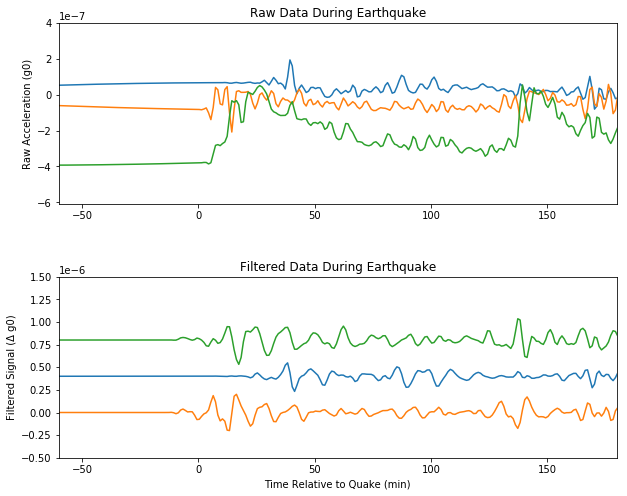

In [2]:
t_start=(datetime.datetime(2012, 4,11, 4, 0)-datetime.datetime(1970, 1, 1)).total_seconds()
t_end=(datetime.datetime(2012, 4, 11, 16, 0)-datetime.datetime(1970, 1, 1)).total_seconds()
t_start=-3600*1
t_end=3600*3
# # # This checks the Raw data Visually
save_dir='F:\\IGETS Each_Sensor_total\\'
data_dir=listdir(save_dir)


tcrit=(datetime.datetime(2012,4,11,8,38,36)-datetime.datetime(1970, 1, 1)).total_seconds()


f,ax = plt.subplots(2, figsize=(10,8))
f.subplots_adjust(hspace=.4)
p=15
[time,signal]=np.load(save_dir+data_dir[p])
time=np.subtract(time,tcrit)
time=np.divide(time,60)
ax[0].plot(time,signal)
p=20
[time,signal]=np.load(save_dir+data_dir[p]) 
time=np.subtract(time,tcrit)
time=np.divide(time,60)
ax[0].plot(time,signal)
p=17
[time,signal]=np.load(save_dir+data_dir[p])
time=np.subtract(time,tcrit)
time=np.divide(time,60)
ax[0].plot(time,signal)

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[0].set_title("Raw Data During Earthquake")
plt.xlabel("Time (min)")
plt.ylabel("Gravsignal (g0)")
ax[0].set_ylim([-6.1E-7,4E-7])
ax[0].set_xlim([t_start/60,t_end/60])
ax[0].set_ylabel("Raw Acceleration (g0)")

filtered_dir='F:\\IGETS Data Long NPoly Filter\\'
p=15
[time_filtered,signal_filtered1]=np.load(filtered_dir+data_dir[p]) 
time_filtered=np.subtract(time_filtered,tcrit)
time_filtered=np.divide(time_filtered,60)
ax[1].plot(time_filtered,np.add(signal_filtered1,4E-7))
p=20
[time_filtered,signal_filtered2]=np.load(filtered_dir+data_dir[p]) 
time_filtered=np.subtract(time_filtered,tcrit)
time_filtered=np.divide(time_filtered,60)
ax[1].plot(time_filtered,signal_filtered2)
p=17
[time_filtered,signal_filtered3]=np.load(filtered_dir+data_dir[p]) 
time_filtered=np.subtract(time_filtered,tcrit)
time_filtered=np.divide(time_filtered,60)
ax[1].plot(time_filtered,np.add(signal_filtered3,8E-7))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[1].set_title("Filtered Data During Earthquake")
plt.xlabel("Time Relative to Quake (min)")
plt.ylabel("Filtered Signal (Δ g0)")
ax[1].set_xlim([t_start/60,t_end/60])
ax[1].set_ylim([-5E-7,15E-7])
plt.show(f)




C:\Users\Rees\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


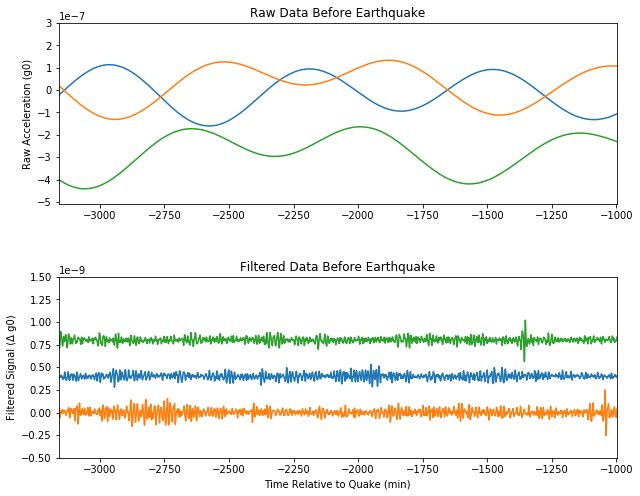

In [3]:
t_start=(datetime.datetime(2012, 4,9, 4, 0)-datetime.datetime(1970, 1, 1)).total_seconds()
t_end=(datetime.datetime(2012, 4, 10, 16, 0)-datetime.datetime(1970, 1, 1)).total_seconds()
# # # This checks the Raw data Visually
save_dir='F:\\IGETS Each_Sensor_total\\'
data_dir=listdir(save_dir)


tcrit=(datetime.datetime(2012,4,11,8,38,36)-datetime.datetime(1970, 1, 1)).total_seconds()
t_start=np.subtract(t_start,tcrit)
t_end=np.subtract(t_end,tcrit)

f,ax = plt.subplots(2, figsize=(10,8))
f.subplots_adjust(hspace=.4)
p=15
[time,signal]=np.load(save_dir+data_dir[p])
time=np.subtract(time,tcrit)
time=np.divide(time,60)
ax[0].plot(time,signal)
p=20
[time,signal]=np.load(save_dir+data_dir[p]) 
time=np.subtract(time,tcrit)
time=np.divide(time,60)
ax[0].plot(time,signal)
p=17
[time,signal]=np.load(save_dir+data_dir[p])
time=np.subtract(time,tcrit)
time=np.divide(time,60)
ax[0].plot(time,signal)

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[0].set_title("Raw Data Before Earthquake")
plt.xlabel("Time (min)")
plt.ylabel("Gravsignal (g0)")
ax[0].set_ylim([-5.1E-7,3E-7])
ax[0].set_xlim([t_start/60,t_end/60])

ax[0].set_ylabel("Raw Acceleration (g0)")

filtered_dir='F:\\IGETS Data Long NPoly Filter\\'
p=15
[time_filtered,signal_filtered1]=np.load(filtered_dir+data_dir[p]) 
time_filtered=np.subtract(time_filtered,tcrit)
time_filtered=np.divide(time_filtered,60)
ax[1].plot(time_filtered,np.add(signal_filtered1,4E-10))
p=20
[time_filtered,signal_filtered2]=np.load(filtered_dir+data_dir[p]) 
time_filtered=np.subtract(time_filtered,tcrit)
time_filtered=np.divide(time_filtered,60)
ax[1].plot(time_filtered,signal_filtered2)
p=17
[time_filtered,signal_filtered3]=np.load(filtered_dir+data_dir[p]) 
time_filtered=np.subtract(time_filtered,tcrit)
time_filtered=np.divide(time_filtered,60)
ax[1].plot(time_filtered,np.add(signal_filtered3,8E-10))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[1].set_title("Filtered Data Before Earthquake")
plt.xlabel("Time Relative to Quake (min)")
plt.ylabel("Filtered Signal (Δ g0)")
ax[1].set_xlim([t_start/60,t_end/60])
ax[1].set_ylim([-5E-10,15E-10])
plt.show(f)




C:\Users\Rees\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


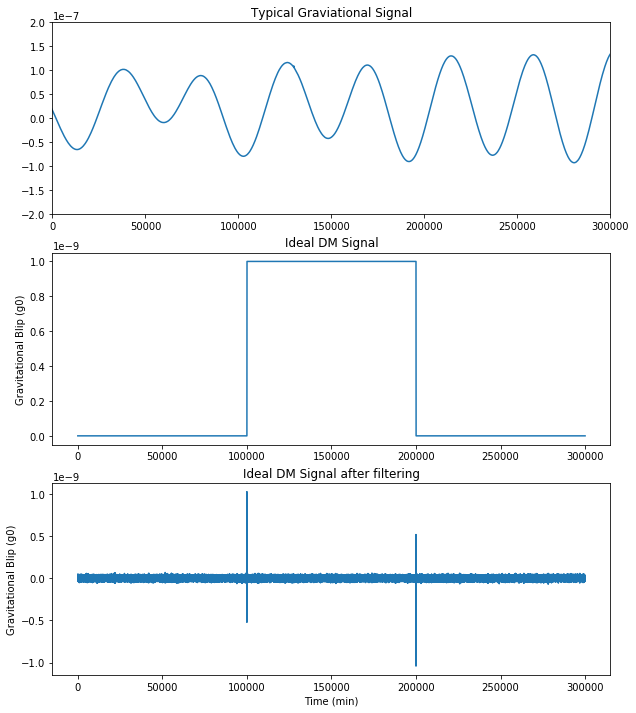

In [4]:
# Ths block, I play with the response generate filter to a unitary signal
tlen=10000
noise_amp=0E-11
back_amp=0
blip_start=100000
per=100000
tlen=2*blip_start+per
blip_amp=1E-9
time,raw_signal=Gravimeter_Sim(tlen,blip_start,blip_start+per,blip_amp,noise_amp,back_amp)
filt_width=5
order=1
tpros,sig_process=Long_Region_N_Point_Poly_Filter(time,raw_signal,filt_width,order)



f,ax = plt.subplots(3, figsize=(10,12))

[time,signal]=np.load(save_dir+data_dir[p])
tcrit=(datetime.datetime(2012,4,1,8,38,36)-datetime.datetime(1970, 1, 1)).total_seconds()
time=np.subtract(time,tcrit)
ax[0].plot(time,np.add(signal,3E-7))
ax[0].set_title("Typical Graviational Signal")
ax[0].set_xlim([0,tlen])
ax[0].set_ylim([-2E-7,2E-7])


ax[1].plot(raw_signal)
ax[1].set_title("Ideal DM Signal")
ax[1].set_ylabel("Gravitational Blip (g0)")

# Ths block, I play with the response generate filter to a unitary signal
tlen=10000
noise_amp=1E-11
back_amp=0
blip_start=100000
per=100000
tlen=2*blip_start+per
blip_amp=1E-9
time,raw_signal=Gravimeter_Sim(tlen,blip_start,blip_start+per,blip_amp,noise_amp,back_amp)
filt_width=5
order=1
tpros,sig_process=Long_Region_N_Point_Poly_Filter(time,raw_signal,filt_width,order)

ax[2].plot(tpros,sig_process)
ax[2].set_title("Ideal DM Signal after filtering")
ax[2].set_xlabel("Time (min)")
ax[2].set_ylabel("Gravitational Blip (g0)")

plt.show(f)

C:\Users\Rees\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


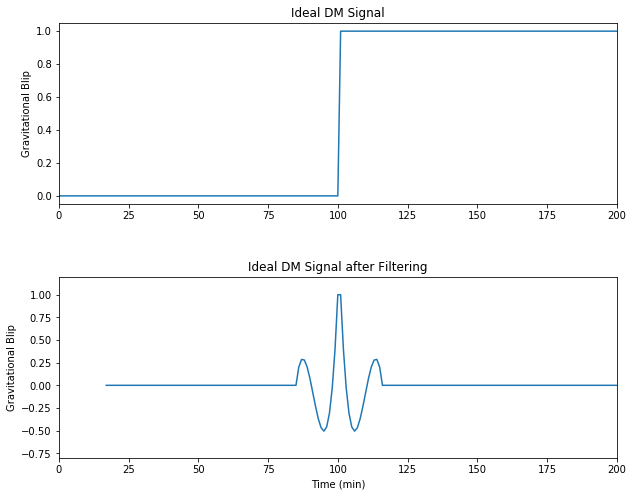

In [5]:
# Ths block, I play with the response generate filter to a unitary signal
tlen=10000
noise_amp=0E-11
back_amp=0
blip_start=100
per=1000
tlen=2*blip_start+per
blip_amp=1
time,raw_signal=Gravimeter_Sim(tlen,blip_start,blip_start+per,blip_amp,noise_amp,back_amp)
filt_width=5
order=1
tpros,sig_process=Long_Region_N_Point_Poly_Filter(time,raw_signal,filt_width,order)



f,ax = plt.subplots(2, figsize=(10,8))
f.subplots_adjust(hspace=.4)

ax[0].plot(raw_signal)
ax[0].set_title("Ideal DM Signal")
ax[0].set_ylabel("Gravitational Blip")
ax[0].set_xlim([0,200])

# Ths block, I play with the response generate filter to a unitary signal
tlen=10000
noise_amp=0E-11
back_amp=0
tlen=2*blip_start+per
blip_amp=1
time,raw_signal=Gravimeter_Sim(tlen,blip_start,blip_start+per,blip_amp,noise_amp,back_amp)
filt_width=15
order=2
tpros,sig_process=Long_Region_N_Point_Poly_Filter(time,raw_signal,filt_width,order)

ax[1].plot(tpros,sig_process)
ax[1].set_title("Ideal DM Signal after Filtering")
ax[1].set_xlabel("Time (min)")
ax[1].set_ylabel("Gravitational Blip")
ax[1].set_xlim([0,200])
ax[1].set_ylim([-.8,1.2])
plt.show(f)

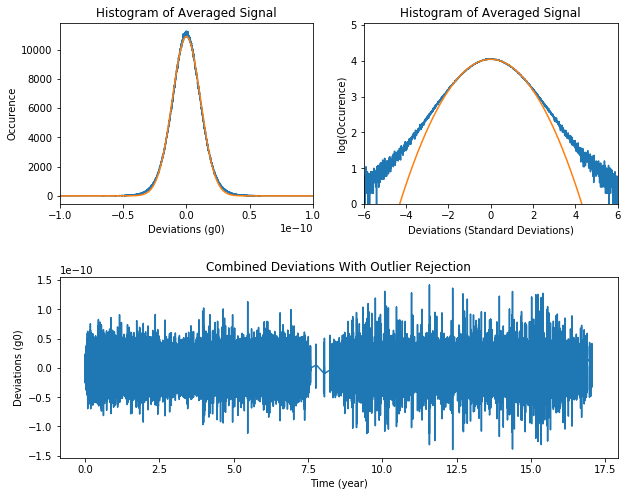

In [6]:
# This data set uses a porbably unjustified level of filtering. I am essentially throwing away every
# single 5 sigma event, without any additional input. May also through away DM blips.

save_trimmed_dir='F:\\IGETS Data NPoly Filter Trim Combined\\10_15_2018_Long_8_p8.npy'


[time_real,filt_signal]=np.load(save_trimmed_dir)   
time_year=np.divide(np.subtract(time_real,time_real[0]),365*24*3600)


f = plt.figure(figsize=(10,8))
ax1 = f.add_subplot(212)
ax1.plot(time_year,filt_signal)
ax1.set_title("Combined Deviations With Outlier Rejection")
ax1.set_xlabel("Time (year)")
ax1.set_ylabel("Deviations (g0)")



histbins=5000
histy,histx=np.histogram(filt_signal,bins=histbins)
histx=histx[:-1]-(histx[0]-histx[1])/2
popt,pcov = curve_fit(gaussian,histx,histy,p0=[max(histy),0,15E-12])

ax2 = f.add_subplot(221)
ax2.plot(histx,histy)
ax2.plot(histx,gaussian(histx,*popt))
ax2.set_title("Histogram of Averaged Signal")
ax2.set_xlabel("Deviations (g0)")
ax2.set_ylabel("Occurence")
ax2.set_xlim([-1E-10,1E-10])


ax3 = f.add_subplot(222)
ax3.plot(np.divide(histx,popt[2]),np.log10(np.add(histy,.00000001)))
ax3.plot(np.divide(histx,popt[2]),np.log10(gaussian(histx,*popt)))
ax3.set_title("Histogram of Averaged Signal")
ax3.set_xlabel("Deviations (Standard Deviations)")
ax3.set_ylabel("log(Occurence)")
ax3.set_xlim([-6,6])
ax3.set_ylim([0,max(np.log10(np.add(histy,.00001)))+1])
f.subplots_adjust(hspace=.4)
plt.show(f)


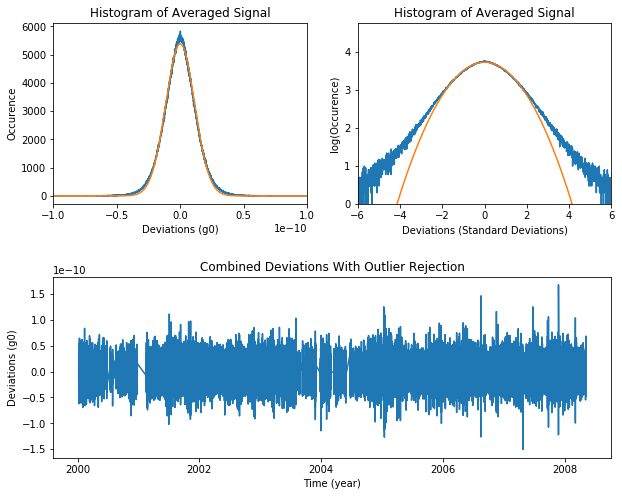

In [7]:
# These data sets are much more realistic, with data filtered based on noise XXX times average over a 
# YYY region of time (to elimate locally noisy days and earthquakes)


#save_trimmed_dir='F:\\IGETS Data NPoly Filter Trim Combined\\10_16_2018_Noise_8_7p5_sjump.npy'
save_trimmed_dir='F:\\IGETS Data NPoly Filter Trim Combined\\10_31_2018_Noise_8_7p5_sjump.npy'


[time_real,filt_signal]=np.load(save_trimmed_dir)   
time_real=time_real[0:int(len(time_real)/2.4)]
filt_signal=filt_signal[0:int(len(filt_signal)/2.4)]

#time_year=np.divide(np.subtract(time_real,time_real[0]),365*24*3600)
time_year=np.add(np.divide(time_real,365*24*3600),1970)

f = plt.figure(figsize=(10,8))
ax1 = f.add_subplot(212)
ax1.plot(time_year,filt_signal)
ax1.set_title("Combined Deviations With Outlier Rejection")
ax1.set_xlabel("Time (year)")
ax1.set_ylabel("Deviations (g0)")



histbins=5000
histy,histx=np.histogram(filt_signal,bins=histbins)
histx=histx[:-1]-(histx[0]-histx[1])/2
popt,pcov = curve_fit(gaussian,histx,histy,p0=[max(histy),0,15E-12])

ax2 = f.add_subplot(221)
ax2.plot(histx,histy)
ax2.plot(histx,gaussian(histx,*popt))
ax2.set_title("Histogram of Averaged Signal")
ax2.set_xlabel("Deviations (g0)")
ax2.set_ylabel("Occurence")
ax2.set_xlim([-1E-10,1E-10])


ax3 = f.add_subplot(222)
ax3.plot(np.divide(histx,popt[2]),np.log10(np.add(histy,.00000001)))
ax3.plot(np.divide(histx,popt[2]),np.log10(gaussian(histx,*popt)))
ax3.set_title("Histogram of Averaged Signal")
ax3.set_xlabel("Deviations (Standard Deviations)")
ax3.set_ylabel("log(Occurence)")
ax3.set_xlim([-6,6])
ax3.set_ylim([0,max(np.log10(np.add(histy,.00001)))+1])
f.subplots_adjust(hspace=.4)
plt.show(f)


C:\Users\Rees\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log10


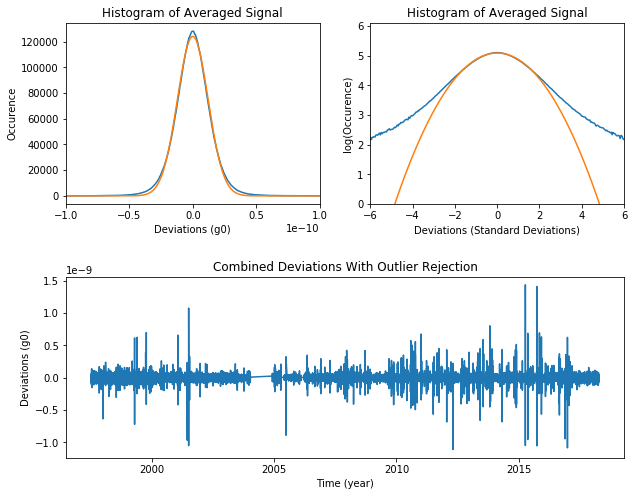

In [8]:
#save_trimmed_dir='F:\\IGETS Data NPoly Filter Trim Combined\\10_16_2018_Noise_8_7p5_sjump.npy'
save_trimmed_dir='F:\\IGETS Data NPoly Filter Trim Combined\\11_03_2018_Noise_6_30_sjump_2.npy'


[time_real,filt_signal]=np.load(save_trimmed_dir)   
# time_real=time_real[0:int(len(time_real)/4.4)]
# filt_signal=filt_signal[0:int(len(filt_signal)/4.4)]

#time_year=np.divide(np.subtract(time_real,time_real[0]),365*24*3600)
time_year=np.add(np.divide(time_real,365*24*3600),1970)

f = plt.figure(figsize=(10,8))
ax1 = f.add_subplot(212)
ax1.plot(time_year,filt_signal)
ax1.set_title("Combined Deviations With Outlier Rejection")
ax1.set_xlabel("Time (year)")
ax1.set_ylabel("Deviations (g0)")



histbins=5000
histy,histx=np.histogram(filt_signal,bins=histbins)
histx=histx[:-1]-(histx[0]-histx[1])/2
popt,pcov = curve_fit(gaussian,histx,histy,p0=[max(histy),0,15E-12])

ax2 = f.add_subplot(221)
ax2.plot(histx,histy)
ax2.plot(histx,gaussian(histx,*popt))
ax2.set_title("Histogram of Averaged Signal")
ax2.set_xlabel("Deviations (g0)")
ax2.set_ylabel("Occurence")
ax2.set_xlim([-1E-10,1E-10])


ax3 = f.add_subplot(222)
ax3.plot(np.divide(histx,popt[2]),np.log10(np.add(histy,.00000001)))
ax3.plot(np.divide(histx,popt[2]),np.log10(gaussian(histx,*popt)))
ax3.set_title("Histogram of Averaged Signal")
ax3.set_xlabel("Deviations (Standard Deviations)")
ax3.set_ylabel("log(Occurence)")
ax3.set_xlim([-6,6])
ax3.set_ylim([0,max(np.log10(np.add(histy,.00001)))+1])
f.subplots_adjust(hspace=.4)
plt.show(f)


C:\Users\Rees\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in log10
C:\Users\Rees\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


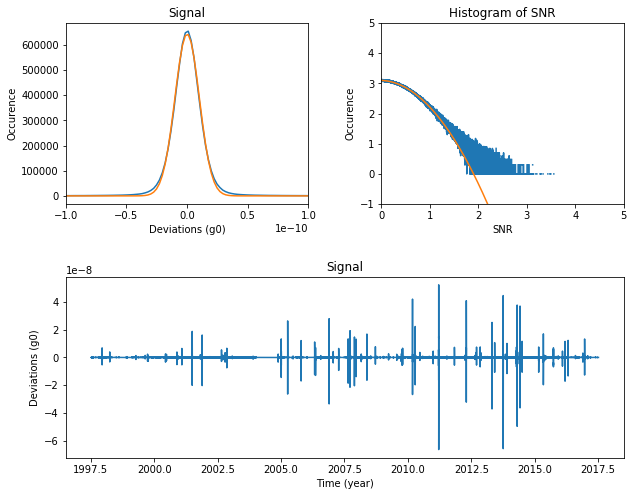

In [12]:
#filename='11_03_2018_Noise_6_30_sjump_2.npy'
#filename='11_05_2018_Noise_6_50_sjump_2.npy'
#filename='11_06_2018_Noise_3_25_sjump_3.npy'
#filename='11_06_2018_Noise_1_25_sjump_3.npy'
#filename='11_06_2018_Noise_4_25_sjump_3.npy'
#filename='11_06_2018_Noise_6_25_sjump_3.npy'

#These two is my favorite balance, for cut data
filename='11_06_2018_Noise_6_25_sjump_3.npy'
filename='11_06_2018_Noise_5_25_sjump_3.npy'

#This, is with no data trimming (for earthquakes and stuff) at all.
filename='11_09_2018_Noise_6_notrim_sjump_3.npy'
filename='11_26_2018_Noise_7_notrim_sjump_3.npy'

save_SNR_dir='F:\\IGETS Data NPoly SNR\\'
[time_process,fitval,fiterr,signal_quad,noise]=np.load(save_SNR_dir+filename)
SNR=np.divide(signal_quad,noise)
time_year=np.add(np.divide(time_process,365*24*3600),1970)
filt_signal=fitval


f = plt.figure(figsize=(10,8))
f.subplots_adjust(hspace=.3)
f.subplots_adjust(wspace=.3)
ax1 = f.add_subplot(212)
ax1.plot(time_year,filt_signal)
ax1.set_title("Signal")
ax1.set_xlabel("Time (year)")
ax1.set_ylabel("Deviations (g0)")


histbins=50000
histy,histx=np.histogram(filt_signal,bins=histbins)
histx=histx[:-1]-(histx[0]-histx[1])/2
popt,pcov = curve_fit(gaussian,histx,histy,p0=[max(histy),0,15E-12])

ax2 = f.add_subplot(221)
ax2.plot(histx,histy)
ax2.plot(histx,gaussian(histx,*popt))
ax2.set_title("Signal")
ax2.set_xlabel("Deviations (g0)")
ax2.set_ylabel("Occurence")
ax2.set_xlim([-1E-10,1E-10])

histbins=50000
histy,histx=np.histogram(np.divide(signal_quad,noise),bins=histbins)
histx=histx[:-1]-(histx[0]-histx[1])/2
popt,pcov = curve_fit(gaussian,histx,histy,p0=[max(histy),0,1])

ax3 = f.add_subplot(222)
ax3.plot(np.divide(histx,1),np.log10(np.add(histy,0)))
ax3.plot(np.divide(histx,1),np.log10(gaussian(histx,*popt)))
ax3.set_title("Histogram of SNR")
ax3.set_xlabel("SNR")
ax3.set_ylabel("Occurence")
ax3.set_xlim([-0,5])
ax3.set_ylim([-1,5])

#ax3.set_ylim([0,max(np.log10(np.add(histy,.00001)))+1])
f.subplots_adjust(hspace=.4)
plt.show(f)



In [ ]:
hba